# Mortgage Default Prediction - FICO Score Binning

In this notebook, we will analyse FICO scores from a mortgage dataset to create optimal buckets that can be used to predict the probability of default (PD). The goal is to find the best way to bin FICO scores into a set number of categories that can be used in a machine learning model.

## Step 1: Load and Explore the Data

First, we will load the dataset and explore its structure.

In [65]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
import seaborn as sns

In [66]:
# Load the data
file_path = 'Task 3 and 4_Loan_Data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


## Step 2: Explore the Distribution of FICO Scores

We will visualise the distribution of FICO scores to understand their range and frequency.

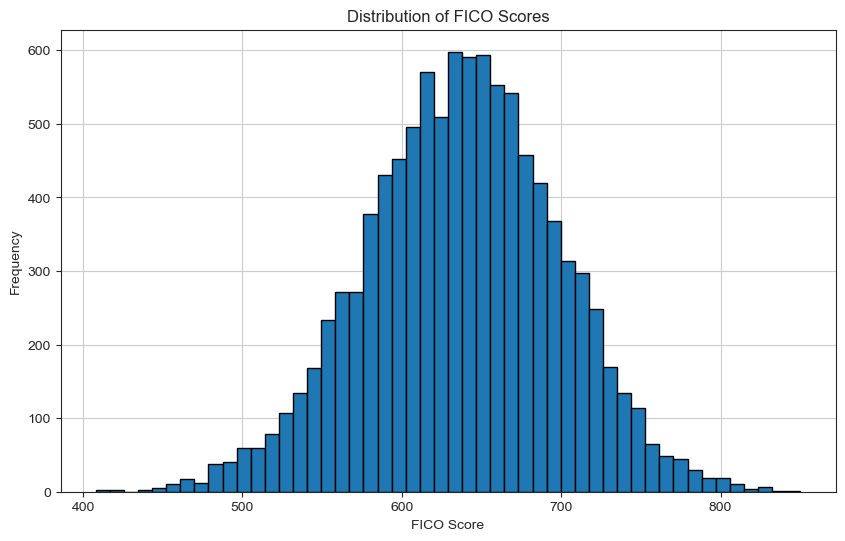

In [68]:
# Plot the distribution of FICO scores
plt.figure(figsize=(10, 6))
plt.hist(df['fico_score'], bins=50, edgecolor='k')
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Step 3: Data Preparation

We need to prepare the data by calculating cumulative defaults and totals for each FICO score.

In [70]:
# Prepare the data
x = df['default'].tolist()
y = df['fico_score'].tolist()
n = len(x)

default = [0] * 551  # For FICO scores 300 to 850
total = [0] * 551

# Calculate defaults and totals
for i in range(n):
    y[i] = int(y[i])
    index = y[i] - 300
    default[index] += x[i]
    total[index] += 1

# Calculate cumulative defaults and totals
for i in range(1, 551):
    default[i] += default[i - 1]
    total[i] += total[i - 1]

## Step 4: Define the Log-Likelihood Function

We will use the log-likelihood function to evaluate the quality of our bins.

In [72]:
# Define log-likelihood function
def log_likelihood(n, k):
    if n == 0:
        return 0
    p = k / n
    if p == 0 or p == 1:
        return 0
    return k * log(p) + (n - k) * log(1 - p)

## Step 5: Dynamic Programming for Optimised Binning

Using dynamic programming, we will find the optimal boundaries for the buckets to maximise the log-likelihood.

In [74]:
# Dynamic programming for optimised binning
r = 10  # Number of buckets
dp = [[[-10**18, 0] for _ in range(551)] for _ in range(r + 1)]

for i in range(r + 1):
    for j in range(551):
        if i == 0:
            dp[i][j][0] = 0
        else:
            for k in range(j):
                if total[j] == total[k]:
                    continue
                if i == 1:
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                else:
                    new_ll = dp[i - 1][k][0] + log_likelihood(total[j] - total[k], default[j] - default[k])
                    if dp[i][j][0] < new_ll:
                        dp[i][j][0] = new_ll
                        dp[i][j][1] = k

# Extract bucket boundaries
k = 550
l = []
current_r = r
while current_r > 0:
    l.append(k + 300)
    k = dp[current_r][k][1]
    current_r -= 1

# Reverse to get boundaries in ascending order
l.reverse()

# Print results
print("Log-Likelihood:", round(dp[r][550][0], 4))
print("Bucket Boundaries:", l)

Log-Likelihood: -4217.8245
Bucket Boundaries: [520, 552, 580, 611, 649, 696, 732, 752, 753, 850]


## Step 6: Results

We have successfully calculated the optimal bucket boundaries for the FICO scores. These boundaries can now be used in a machine learning model to predict the probability of default.